In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from timeit import default_timer as t_now

In [2]:
from datacube import Datacube
from datacube.storage.storage import measurement_paths
from dea.io.pdrill import PixelDrill
from dea.aws.rioworkerpool import RioWorkerPool

dc = Datacube(env='wofs')

## Setup PixelDrill Worker Pool

In [3]:
nthreads = 32
pool = RioWorkerPool(nthreads=nthreads, max_header_sz_kb=32)
pdrill = PixelDrill(pool)

## Query Datacube

- Find datasets
- Sort them by time
- Extract urls for a band of interest (`water` in this case)
- Extract timestamps

In [4]:
lon_lat = (148.02310311982876, -35.33091506569685)

In [5]:
%%time
lon, lat = lon_lat
dss = dc.find_datasets(product='wofs_albers', lon=lon, lat=lat)

CPU times: user 671 ms, sys: 20 ms, total: 691 ms
Wall time: 779 ms


In [6]:
%%time
dss = sorted(dss, key=lambda ds: ds.center_time)

CPU times: user 43.2 ms, sys: 0 ns, total: 43.2 ms
Wall time: 42.4 ms


In [7]:
tt = [ds.center_time for ds in dss]
urls = [measurement_paths(ds)['water'] for ds in dss]

## Warmup The Pool

This is not needed in the real app. Very first file `open` takes significantly longer than consequent `open` calls as GDAL configures various per-thread structures. Since in the real app we expect to re-use worker threads, this cost will get amortised across many requests. But to get more accurate timing measures in the Load Pixels section we perform "pool warmup here".

In [8]:
%%time
pix_warmup = pdrill.lazy_read([urls[-1]]*nthreads, pixel=(0,0)).result()

CPU times: user 2.95 s, sys: 1.89 s, total: 4.84 s
Wall time: 2.38 s


## Load Pixels

In [9]:
%%time
t0 = t_now()
pix = pdrill.lazy_read(urls, lonlat=lon_lat) # this should return quickly
t1 = t_now()
pix = pix.result() # This will block until all files are loaded
t2 = t_now()

CPU times: user 7.52 s, sys: 775 ms, total: 8.29 s
Wall time: 3.14 s


In [10]:
t_total = t2 - t0
fps = len(urls)/t_total

print('''
- {:d} worker threads
- {:,d} files
- {:.3f} seconds to completion ({:.1f} ms to schedule)
- {:.1f} fps ({:.1f} per thread)
'''.format(nthreads,
           len(urls), 
           t_total,
           (t1-t0)*1000,
           fps, 
           fps/nthreads))


- 32 worker threads
- 1,539 files
- 3.144 seconds to completion (77.7 ms to schedule)
- 489.5 fps (15.3 per thread)



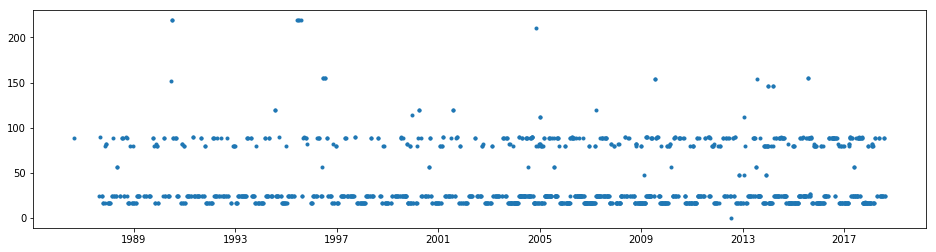

In [11]:
fig,ax = plt.subplots(1,1, figsize=(16,4))
plt.plot(tt, pix, '.');

-----------------------------------------------